<a href="https://colab.research.google.com/github/Yalnyra/CaBuAr-segmentation-learning/blob/main/Vinokur_Pretrained3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




















# 3. Претренована модель (Resnet, Inceptionv4)

In [15]:
# Image load

import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
# import torchvision
from torchvision.transforms import v2 as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# import wandb

In [31]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
URL = "drive/MyDrive/Intel-Image-Classification"
# Альтернативний шлях, якщо працюєте з kaggle
# URL = "/kaggle/input/intel-image-classification"
folder = {"kaggle": 'seg_pred/seg_pred',
          'train': 'seg_train/seg_train',
          'test': 'seg_test/seg_test'
          }
BATCH_SIZE = 64
_NUM_WORKERS = os.cpu_count() // 2
_INPUT_SIZE = 150
SEED = 1234

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [19]:
from google.colab import drive

In [36]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
rng = np.random.default_rng(seed=SEED)

In [22]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Імплементація зверху дуже повільна

In [35]:
URL

'drive/MyDrive/Intel-Image-Classification'

[Пост з stackoverlow](https://discuss.pytorch.org/t/accelerate-imagefolder-based-dataset-loading/195120/2) для пришвидшення завантаження



In [24]:
import h5py

In [25]:
INPUT_SIZE = 150

In [33]:
def create_hdf5_dataset(root_folder: str,
                        hdf5_file: str,
                        target_size: tuple[int, int] = (INPUT_SIZE, INPUT_SIZE),
                        channels: int = 3) -> None:
    """ Create an hdf5 database file from a folder containing images.
    The images are resized to the target_size and stored in the hdf5 file.
    This is useful when your dataset cannot fit in RAM and the data consits of many images"""
    transform = transforms.Compose([
        transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
        transforms.CenterCrop((150,150)),
        transforms.ToTensor(),
    ])

    # check if data_dir points towards an existing directory
    if not os.path.isdir(root_folder):
        error_string = f"Directory '{root_folder}' not found."
        raise FileNotFoundError(error_string)

    # generate dataset
    try:
        data = datasets.ImageFolder(root=root_folder, transform=transform)
        # set chunk size for loading data and appending to hdf5 file
        chunk_size = min(int(len(data) / 10), 1000)
    except Exception as e:
        raise e

    num_images = len(data)

    # open the hdf5 file
    with h5py.File(hdf5_file, "w") as file:
        # Create datasets with chunks for efficient storage
        img_dataset = file.create_dataset("images", shape=(num_images,
                                                           channels,
                                                           target_size[0],
                                                           target_size[1]),
                                          dtype="float32", chunks=None)
        lbl_dataset = file.create_dataset("labels", shape=(num_images,),
                                          dtype="int64", chunks=None)
        print(img_dataset.shape)
        loader = DataLoader(data, batch_size=chunk_size, shuffle=False, num_workers=_NUM_WORKERS)

        current_index = 0
        # start batch processing (to avoid RAM overflow)
        for images, labels in tqdm(loader):
            chunk_size = images.size(0)

            images = np.array(images)
            labels = np.array(labels)

            img = torch.tensor(images, dtype=torch.float32)
            # img = torch.permute(img, (0, 2, 1, 3))
            lbl = torch.tensor(labels, dtype=torch.long)

            img_dataset[current_index:current_index + chunk_size] = img
            lbl_dataset[current_index:current_index + chunk_size] = lbl
            print(img_dataset.shape)
            current_index += chunk_size

In [27]:
""" Custom dataset for loading images from an hdf5 file.
    This system lazy loads the images from the hdf5 file."""

class Hdf5Dataset(Dataset):
    def __init__(self, hdf5_file: str, transform: transforms = None) -> None:
        self.hdf5_file = hdf5_file
        self.transform = transform
        self.dataset = None

        with h5py.File(hdf5_file, "r") as file:
            self.length = len(file["images"])

    def __len__(self) -> int:
        return self.length
        print(self.length)

    def classes(self):
      return np.unique()

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        """ Returns a tuple of image and label."""
        if self.dataset is None:
            self.dataset = h5py.File(self.hdf5_file, mode="r", swmr=True)

        image = self.dataset["images"][idx]
        label = self.dataset["labels"][idx]
        # assert dataset is not None
        image = np.permute_dims(image, (2,1,0))
        # print(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [28]:
"""
Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied on a sample.
"""

train_dir = os.path.join(URL, folder['train'])
test_dir  = os.path.join(URL, folder['test'])
train_hdf5 = os.path.join(train_dir,'train.hdf5')
test_hdf5 = os.path.join(test_dir,'test.hdf5')

In [29]:
train_hdf5

'drive/MyDrive/Intel-Image-Classification/seg_train/seg_train/train.hdf5'

Експортуємо дані у ту саму папку один раз, але у єдиному файлі .hdf5

In [38]:
if not os.path.isfile(train_hdf5):
  create_hdf5_dataset(train_dir, train_hdf5)
if not os.path.isfile(test_hdf5):
  create_hdf5_dataset(test_dir, test_hdf5)


In [39]:
# # Create the dataset
# dataset = Hdf5Dataset(train_hdf5, transform=transform)

# # Access an image tensor and its label
# image_tensor, label = dataset[0]
# print(image_tensor.shape, label)

In [40]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [41]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

### Важкі трансформації - на додачу до афінних перетворень шум, блюр, RandomFlip

In [42]:
affine_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1,1), antialias=True),
    # transforms.RandomHorizontalFlip(p=0.),
])

augmentations = transforms.Compose([
    transforms.GaussianNoise(sigma=0.1),
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
])

In [43]:
color_transforms = transforms.Compose([
    # transforms.Normalize(features_mean, features_std),
    transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.01),
])

In [44]:
repeats = 50
features_size = BATCH_SIZE * repeats

In [45]:
# features_mean = torch.zeros(1)
# features_squared_mean = torch.zeros(1)
# # Only use a few batches
# for item, label in data_train:
#     item = test_transforms(item)
#     features_mean += torch.mean(item)
#     features_squared_mean += torch.mean(item ** 2)
#     print(repeats)
#     repeats -= 1
#     if repeats <= 0:
#       break

# features_mean /= features_size
# features_squared_mean /= features_size

# features_std = torch.sqrt(features_squared_mean - features_mean ** 2)

In [46]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.CenterCrop((150,150)),
    ])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [47]:
train_transforms = transforms.Compose([
    # transforms.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    # transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    # transforms.CenterCrop((150,150)),
  #   transforms.RandomApply([
  #   transforms.RandomChoice([
    affine_transforms,
    # augmentations,
  #       # color_transforms,
  #   ],)
  # ], p=0.2),
  transforms.RandomGrayscale(p=0.2),
  # transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),
])


In [48]:
heavy_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(150 , 150)) ,
    transforms.RandomCrop(size=(150,150)),
    # transforms.ColorJitter(0.4,0.0,0.0,0.0),
    transforms.GaussianNoise(sigma=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomGrayscale(p=0.2),
    # transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

In [49]:
model_path = lambda name: f"{URL}/{name}.pt"

In [50]:
if not os.path.exists(model_path('')):
      os.makedirs(model_path(''))

In [51]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [52]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X), pred, y.view(*pred.shape)

У циклі валідації було вставлено scheduler для ReduceOnPlateau

І заміна train_loader на heavy_loader

In [53]:
def fit(epochs, model, loss_func, optimizer, train_loader, heavy_loader, valid_loader, lr_scheduler=None, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.inf
    step = 0
    for epoch in tqdm(range(epochs)):
        step = epoch
        fraction = step / epochs
        # Change the transforms based on epochs
        # train_loader = valid_loader if fraction >= 0.8 else train_transforms
        train_loader = heavy_loader if fraction >= 0.1 and fraction <= 0.6 else train_loader
        model.train()

        losses = []

        for X, y  in train_loader:
          # print(X.shape)
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()
        # valid_loader.dataset.transform = test_transforms
        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))
              if lr_scheduler is not None:
                lr_scheduler.step()



            losses, corrects, nums, predicted, target = zip(*losses)
            target = torch.cat([*target], dim=0).cpu()
            predicted = torch.cat([*predicted],dim=0).cpu()
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100
            # Changed from total class per-point  to average weighted
            valid_precision = precision_score(target, predicted, average='weighted')
            valid_recall = recall_score(target, predicted,  average='weighted')
            valid_f1 = f1_score(target, predicted,  average='weighted')

            # reduce lr based on val loss
            # if lr_scheduler is not None:
            #   lr_scheduler.step(valid_loss)

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accuracy: {valid_accuracy:.3f}, valid f1: {valid_f1:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1))
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                # if wait >= patience:
                #     print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                #     return graphic_losses, step

    return graphic_losses, step

### Тестування моделі

- На додачу до простого Accuracy, потрібно знайти
Precision
$TP \div (TP+FP)$

Recall
$TN \div (TN+FN)$

F1 $\frac{1}{\frac{1}{Precision}+\frac{1}{Recall}} $

Матрицю зкуйовдженості

In [54]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums, predicted, target = zip(*validated_batches)
        target = torch.cat([*target], dim=0).cpu()
        predicted = torch.cat([*predicted],dim=0).cpu()
        cm = ConfusionMatrixDisplay.from_predictions(target, predicted)
        plt.show()
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100
        test_precision = precision_score(target, predicted,  average='micro')
        test_recall = recall_score(target, predicted,  average='micro')
        test_f1 = f1_score(target, predicted,  average='micro')



    print(f"Test loss: {test_loss:.5f}\t",
          f"Test accuracy: {test_accuracy:.3f}%",
          f"Test precision: {test_precision:.3f}",
          f"Test recall: {test_recall:.3f}"
          f"Test f1: {test_f1:.3f}")
    return test_loss, test_accuracy, test_precision, test_recall, test_f1, cm

In [55]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[3] for x in losses_arr])
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[4] for x in losses_arr])
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[5] for x in losses_arr])
    plt.ylabel('F1')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [56]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

Створимо окремий loader для важчих трансформацій

In [57]:
def train(model, criterion, optimizer, n_epochs, batch_size, lr_scheduler=None, saving_model_path=None, wb = False):

    # data_train = ImageDataset(URL, True, train_transforms

    # data_test = ImageDataset(URL, test_transforms)

    # data_train = datasets.ImageFolder(train_dir, train_transforms)
    # data_test = datasets.ImageFolder(test_dir, test_transforms)
    # Deterministic split to apply transforms
    gen = torch.Generator().manual_seed(42)
    data_train = Hdf5Dataset(train_hdf5, transform=train_transforms)
    data_heavy = Hdf5Dataset(train_hdf5, transform=heavy_transforms)
    data_valid = Hdf5Dataset(train_hdf5, transform=test_transforms)
    # Fix indices
    # num_train = len(data_train)
    # indices = list(range(num_train))
    # train_indices, val_indices = train_test_split(indices, test_size=0.2)
    data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2], generator=gen)
    # _, data_valid = random_split(data_train, lengths=[0.8, 0.2], generator=gen)
    data_heavy, _ = random_split(data_heavy, lengths=[0.8, 0.2], generator=gen)
    # data_train = torch.utils.data.Subset(data_train, train_indices)
    # data_heavy = torch.utils.data.Subset(data_heavy, train_indices)

    # data_valid = torch.utils.data.Subset(data_train, val_indices)
    # data_train.transform = test_transforms

    data_test = Hdf5Dataset(test_hdf5, transform=test_transforms)

    # print(data_train.transform)
    # data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])
    # data_train.dataset.transform = test_transforms


    loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=batch_size, shuffle=True), to_device)
    loader_heavy = WrappedDataLoader(DataLoader(data_heavy, batch_size=batch_size, shuffle=True), to_device)
    loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=batch_size, shuffle=False), to_device)
    loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=batch_size, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    train_losses, final_step = fit(n_epochs, model, criterion, optimizer, loader_train, loader_heavy, loader_eval, lr_scheduler)
    print(f'length array:', len(train_losses))
    print(f'Fit time: {time.time() - start_time} s')
    if wb:
        wandb.log({"train/duration": time.time() - start_time})
    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    eval_losses = evaluate(model, criterion, loader_test)

    if saving_model_path is not None:
        print('Saving model')
        # create 'dynamic' dir, if it does not exist
        if not os.path.exists(model_path('')):
          os.makedirs(model_path(''))
        torch.save(model.state_dict(), model_path(saving_model_path))
        if wb:
            wandb.log_model(path=model_path(saving_model_path),name=saving_model_path)
            for i in range(final_step):
                train_loss, v_loss, v_acc, v_prec, v_recall, v_f1 = train_losses[i]
                wb_dict = {
                    "train/loss": train_loss,
                    "valid/loss": v_loss,
                    "valid/accuracy": v_acc,
                    "valid/precision": v_prec,
                    "valid/recall": v_recall,
                    "valid/f1": v_f1,
                           }
                wandb.log(wb_dict, step=i)
            test_loss, t_acc, t_prec, t_recall, t_f1, fig = eval_losses
            wandb.log({"test/loss": test_loss,
                    "test/accuracy": t_acc,
                    "test/precision": t_prec,
                    "test/recall": t_recall,
                    "test/f1": t_f1}, step=final_step+1)
            wandb.log({"fig":wandb.Image(fig.confusion_matrix)})

    training_plots(train_losses)

In [58]:
# class_weights = torch.tensor(calculate_class_weights(y_train), dtype=torch.float, device=device)
n_epochs = 20
BATCH_SIZE = 32

Backbone Inception-v4 буде завантажено із huggingface

Що було випробувано на 20-30 епохах:

1. Inception з повністю замороженими вагами, lr=0,9 reducelronplato - 79%
2. Resnet-18 num_features->6 класів із замороженими вагами, lr=0,9 onplato - Майже не вчився, претренована вже мав точність 92% на старті
3. 20 епох Resnet-18 num_features->256->6 класів із підмороженими вагами, lr=1e-5, 0,9 = 90%
4. Resnet-50 з підмороженими вагами num_features -> 256->6 lr=5e-6, 0,9
5. Зробив важчі навантаження аугментаціями після 5-10 епох - погіршилося до 81% на тестф

Далі закінчились ресурси колабу

In [59]:
import timm
from torchsummary import summary

In [60]:
pretrained = timm.create_model('inception_v4', pretrained=True)
# num_features = pretrained.last_linear.in_features
# pretrained.last_linear = nn.Linear(num_features, len(classes))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [61]:
from torchvision.models import ResNet18_Weights

# Завантажуємо модель ResNet18 (навчена на ImageNet)
pretrained = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = pretrained.fc.in_features
pretrained.fc = nn.Linear(num_features, len(classes))
print(num_features)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


512


In [62]:
for name, param in pretrained.named_parameters():
    print(name)
    if 'bn' in name:
      print('no grad for:', name)
      param.requires_grad = False



# Переносимо модель на пристрій
pretrained = pretrained.to(device)

conv1.weight
bn1.weight
no grad for: bn1.weight
bn1.bias
no grad for: bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
no grad for: layer1.0.bn1.weight
layer1.0.bn1.bias
no grad for: layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
no grad for: layer1.0.bn2.weight
layer1.0.bn2.bias
no grad for: layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
no grad for: layer1.1.bn1.weight
layer1.1.bn1.bias
no grad for: layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
no grad for: layer1.1.bn2.weight
layer1.1.bn2.bias
no grad for: layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
no grad for: layer2.0.bn1.weight
layer2.0.bn1.bias
no grad for: layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
no grad for: layer2.0.bn2.weight
layer2.0.bn2.bias
no grad for: layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
no grad for: layer2.1.bn1.weight
layer2.1.bn1.bias

In [63]:
summary(pretrained, input_size=(3, INPUT_SIZE, INPUT_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

Підморожена мережа з мінімальним learning ratr

# Модифікуємо шари всередині класу


### Одна моделька використовувалась для всіх :>



In [64]:

class FCNInception(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        # for param in pretrained.parameters() if param:
        #     param.requires_grad = False

        # Модифікуємо останній шар (6 класів)
        num_features = pretrained.fc.in_features
        pretrained.fc = nn.Linear(num_features, len(classes))
        # self.fc1 = nn.Linear(1000, 512) # 32 * 64 # 5400
        # self.backbone.fc = nn.Linear(num_features, len(classes))
        # self.fc2 = nn.Linear(num_features, 256)
        # self.fc3 = nn.Linear(num_features, len(classes))

    def forward(self, x):
      # with torch.no_grad():
      x = self.backbone(x)
      # features = F.relu(self.backbone(x))
      # x = F.relu(self.fc3(features))
      # x = F.relu(self.fc3(x))
      # x = self.fc3(features)
      return x

In [65]:
summary(model, input_size=(3, INPUT_SIZE, INPUT_SIZE))

NameError: name 'model' is not defined

In [72]:
model = FCNInception(pretrained).to(device)
# criterion = nn.CrossEntropyLoss(class_weights)
# criterion = nn.

head = [p for name, p in model.named_parameters() if 'fc' in name]
others = [p for name, p in model.named_parameters() if 'fc' not in name]
criterion = nn.CrossEntropyLoss()
optimizer = Adam([{'params': others, 'lr':1e-5}
    ,{'params': head},], lr=0.0009, weight_decay=1e-3)



In [ ]:
summary(model, input_size=(3, INPUT_SIZE, INPUT_SIZE))

In [ ]:
lr_sch = lr_scheduler.StepLR(optimizer, 30, 0.3)

In [ ]:
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,)

In [ ]:
lr_sch = lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=0.001)

In [ ]:
import wandb

In [ ]:
wandb.login()

In [ ]:
n_epochs = 30
BATCH_SIZE = 128

In [ ]:
model

In [ ]:
with wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="Kaggle-Intel-Image",
        name='part_frozen_resnet',
        group='Backbone',
        config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
        sync_tensorboard=False,
        resume="allow",
    ):

  train(model, criterion, optimizer, n_epochs, BATCH_SIZE, lr_scheduler=lr_sch, saving_model_path='part_frozen_resnet', wb=True)

# Результати за посиланням на [wandb](https://wandb.ai/paradoxv15/Kaggle-Intel-Image/reports/Model-tuning-for-Intel-Image-classifier--VmlldzoxMTgxOTgwMA?accessToken=cdrxm1lrx5ogpevw4hkom89zl87k2dohxqz49q7n0n57vckm15ocyaqm21rx0tp0)

- Завантажимо натреновані ResNet-18
- Отримаємо ConfusionMatrixDisplay і тест метрику
- Відобразимо помилкові класи




In [ ]:
entity = 'paradoxv15'

In [ ]:
api = wandb.Api()
artifact = api.artifact(f"{entity}/Kaggle-Intel-Image/part_frozen_resnet3:v0")


In [ ]:
artifact.download(root='.')

In [67]:
artifact.name

'part_frozen_resnet3:v0'

In [69]:
check_point = torch.load(f'{artifact.name.split(":")[0]}.pt', map_location=device)

In [79]:
pretrained = model.load_state_dict(check_point)

In [80]:
data_train = Hdf5Dataset(train_hdf5, transform=train_transforms)

data_test = Hdf5Dataset(test_hdf5, transform=test_transforms)

data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=False), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False), to_device)

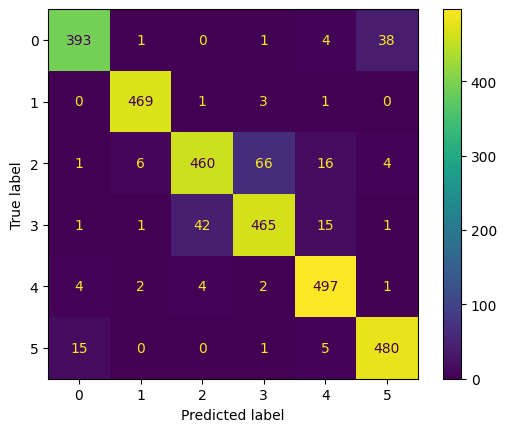

Test loss: 0.25589	 Test accuracy: 92.133% Test precision: 0.921 Test recall: 0.921Test f1: 0.921


In [81]:
eval_losses = evaluate(model, criterion, loader_test)

In [74]:
def validate_examples(model, loss_func, X, y):
    output = model(X)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return X, pred, y.view(*pred.shape)

In [75]:
def draw_predicted_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

In [76]:
# Функція для денормалізації зображення
def denormalize_image(tensor, mean=0.5, std=0.5):
    # tensor має форму (channels, height, width); повертає зображення у форматі HxWxC
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)


# Функція для відображення зображень з прогнозами (оновлено)
def show_predictions(model, dataloader, class_names, device, num_images=8):
    """
    Відображає приклади зображень з прогнозами моделі.
    """
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            labels = labels.cpu()
            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if images_so_far >= num_images:
                    return
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis("off")
                status = "✓" if preds[j] == labels[j] else "✗"
                ax.set_title(
                    f"{status} Predicted: {class_names[pred_label]}\nTarget: {class_names[true_label]}",
                    color="green" if true_label == pred_label else "red",
                    fontsize=10,
                )
                # Використовуємо утиліту для денормалізації
                img = denormalize_image(inputs[j])
                plt.imshow(img)
    plt.tight_layout()
    plt.show()


# Функція для відображення лише помилкових прогнозів (оновлено)
def show_misclassifications(model, dataloader, class_names, device, max_per_class=5):
    """
    Відображає приклади помилково класифікованих зображень для кожного класу.
    """
    model.eval()
    misclassified = {i: [] for i in range(len(class_names))}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if (
                    true_label != pred_label
                    and len(misclassified[true_label]) < max_per_class
                ):
                    img = denormalize_image(inputs[j])
                    misclassified[true_label].append((img, pred_label))

    for class_idx, examples in misclassified.items():
        if not examples:
            continue
        plt.figure(figsize=(15, 3))
        plt.suptitle(
            f"Misclassified as '{class_names[class_idx]}'",
            fontsize=14,
        )
        for i, (img, pred_label) in enumerate(examples):
            plt.subplot(1, len(examples), i + 1)
            plt.imshow(img)
            plt.title(
                f"Target: {class_names[class_idx]}\Predicted: {class_names[pred_label]}",
                color="red",
            )
            plt.axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



Приклади помилкових класифікацій CNN моделі:


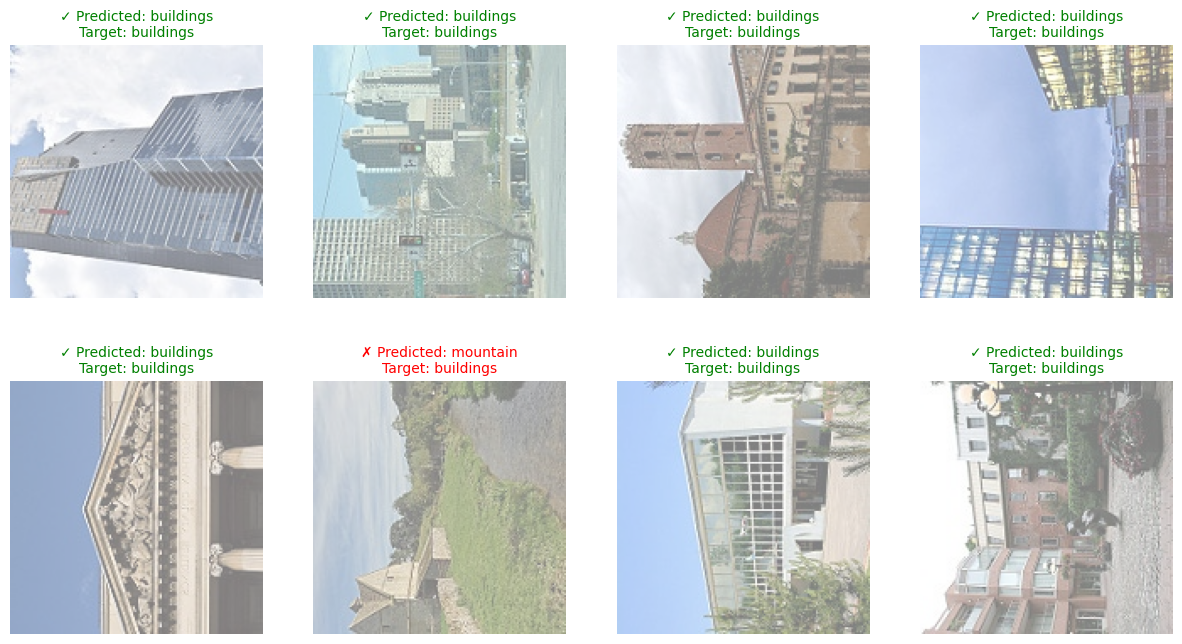

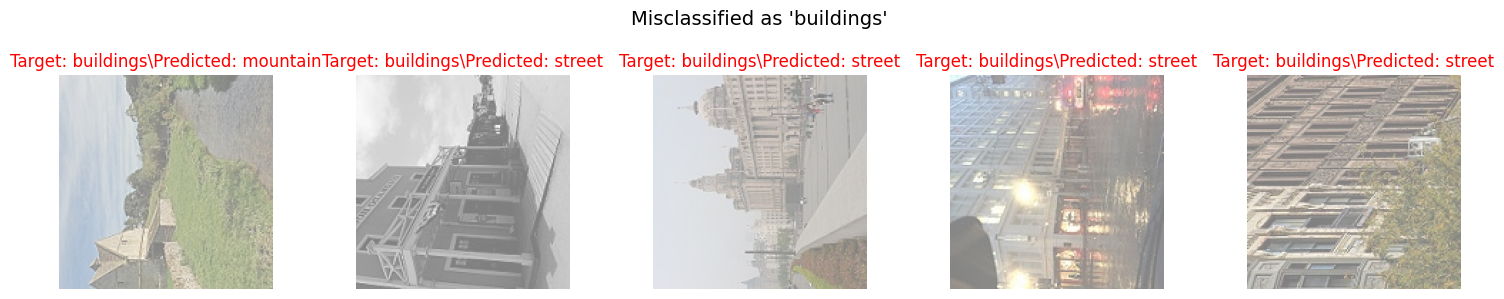

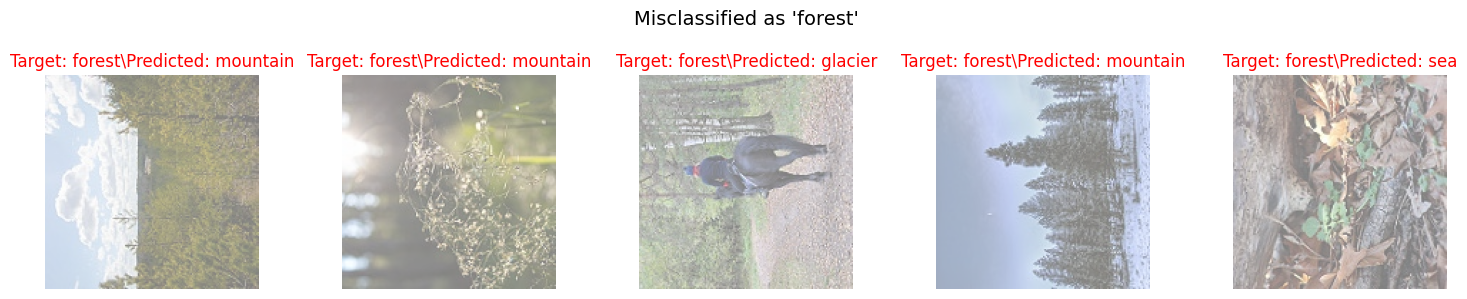

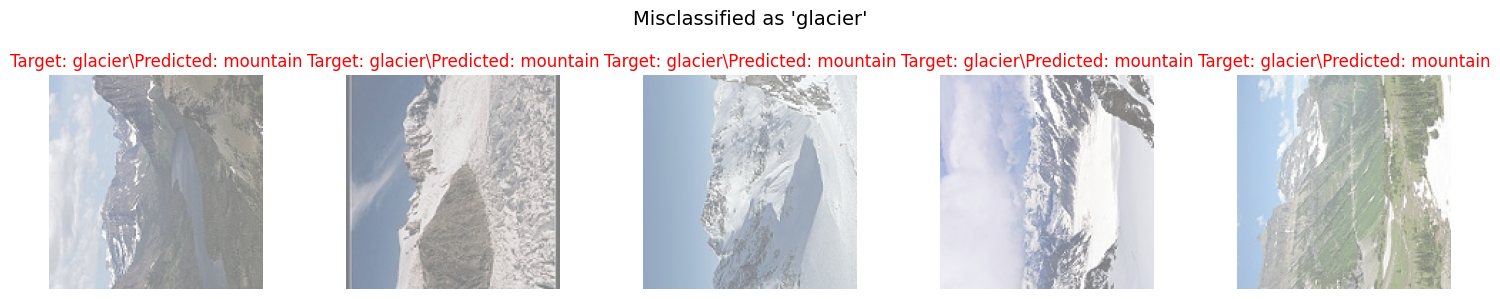

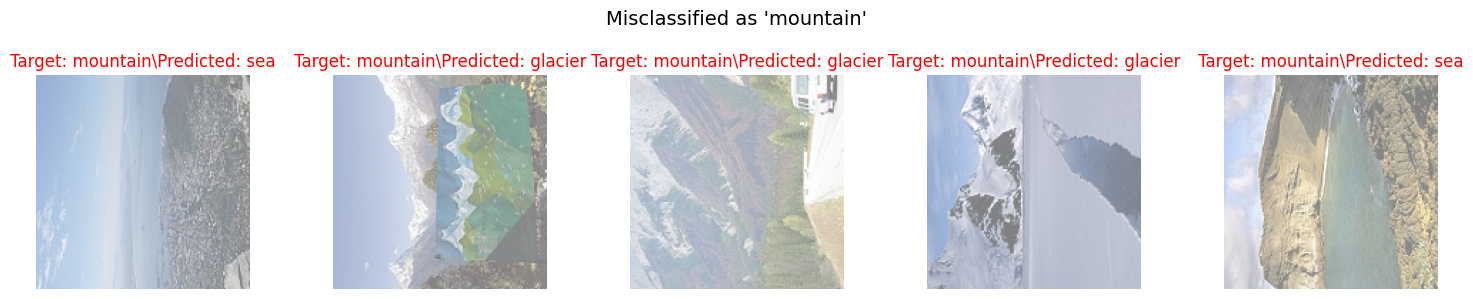

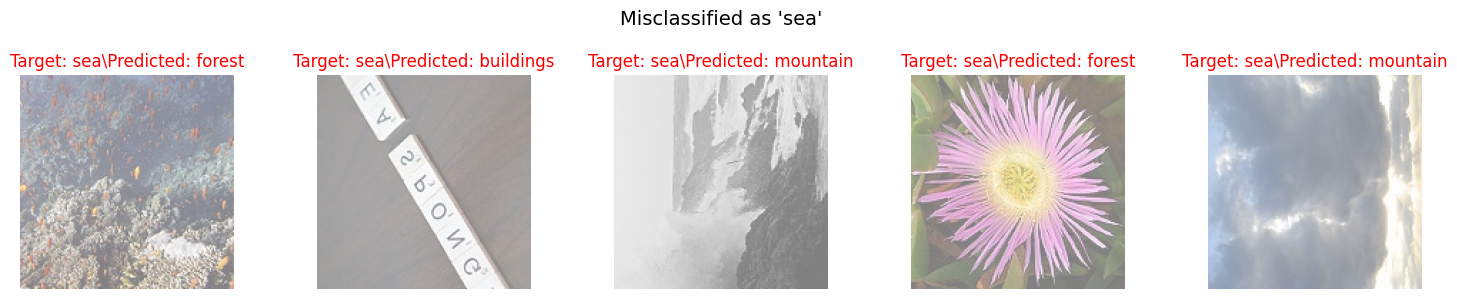

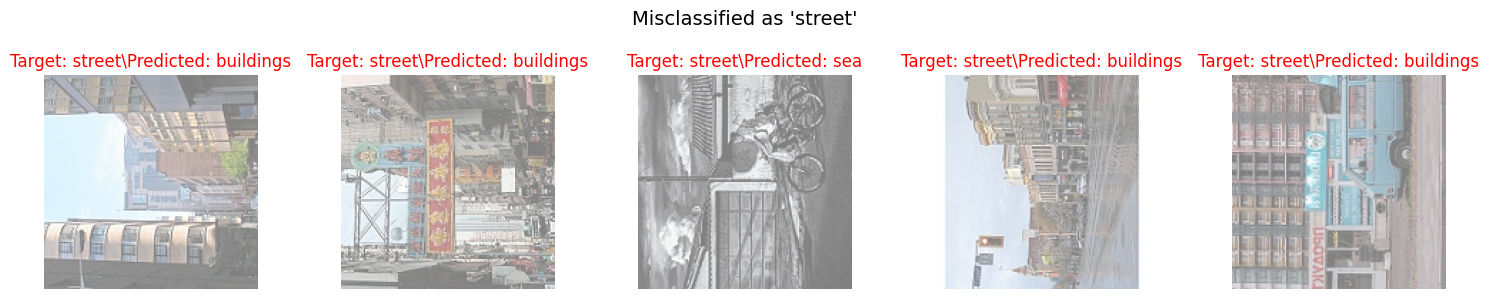

In [78]:
# Показ прикладів прогнозів на валідаційному наборі
show_predictions(model, loader_test, classes, device)

# Показ прикладів ПОМИЛКОВИХ прогнозів для кожного класу
print("\nПриклади помилкових класифікацій CNN моделі:")
show_misclassifications(model, loader_test, classes, device)